In [77]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
import os

In [91]:
root_dir = 'MiniDataset/train'

for label, letter_folder in enumerate(sorted(os.listdir(root_dir))):
    letter_path = os.path.join(root_dir, letter_folder)
    print(label, letter_folder)

0 A
1 B
2 C
3 D
4 E
5 F
6 G
7 H
8 I
9 J
10 K
11 L
12 M
13 N
14 O
15 P
16 Q
17 R
18 S
19 T
20 U
21 V
22 W
23 X
24 Y
25 Z
26 del
27 nothing
28 space


In [ ]:
class SignLanguageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = []
        self.labels = []
        
        for label, letter_folder in enumerate(sorted(os.listdir(root_dir))):
            letter_path = os.path.join(root_dir, letter_folder)
            if os.path.isdir(letter_path):
                for img_name in os.listdir(letter_path):
                    img_path = os.path.join(letter_path, img_name)
                    self.images.append(img_path)
                    self.labels.append(label)  # Assign a numeric label (0-25 for A-Z), (26 for del), (27 for nothing), (28 for space)
                    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = Image.open(self.images[idx]).convert("L")  # Convert to grayscale
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

In [79]:
transform = transforms.Compose([
    transforms.Resize((32, 32)),  # Resize to 32x32 pixels
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize grayscale images
])

In [80]:
train_dataset = SignLanguageDataset(root_dir='MiniDataset/train', transform=transform)
test_dataset = SignLanguageDataset(root_dir='MiniDataset/test', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [81]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 29)  # 26 output classes for A-Z, 3 extra at the end

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.max_pool2d(x, 2)
        x = torch.relu(self.conv2(x))
        x = torch.max_pool2d(x, 2)
        x = x.view(-1, 16 * 5 * 5)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [82]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [83]:
def train_model(model, loader, criterion, optimizer, num_epochs=10):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(loader):.4f}")

In [84]:
def evaluate_model(model, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f'Accuracy: {100 * correct / total:.2f}%')

In [85]:
model = LeNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [86]:
train_model(model, train_loader, criterion, optimizer, num_epochs=200)
evaluate_model(model, test_loader)

Epoch [1/200], Loss: 3.3705
Epoch [2/200], Loss: 3.3677
Epoch [3/200], Loss: 3.3502
Epoch [4/200], Loss: 3.3468
Epoch [5/200], Loss: 3.2908
Epoch [6/200], Loss: 3.2522
Epoch [7/200], Loss: 3.1458
Epoch [8/200], Loss: 3.0988
Epoch [9/200], Loss: 3.0537
Epoch [10/200], Loss: 2.9167
Epoch [11/200], Loss: 2.8660
Epoch [12/200], Loss: 2.9298
Epoch [13/200], Loss: 2.6925
Epoch [14/200], Loss: 2.6837
Epoch [15/200], Loss: 2.5297
Epoch [16/200], Loss: 2.4338
Epoch [17/200], Loss: 2.3708
Epoch [18/200], Loss: 2.0817
Epoch [19/200], Loss: 2.1496
Epoch [20/200], Loss: 1.9202
Epoch [21/200], Loss: 1.7986
Epoch [22/200], Loss: 1.8675
Epoch [23/200], Loss: 1.6445
Epoch [24/200], Loss: 1.7214
Epoch [25/200], Loss: 1.5179
Epoch [26/200], Loss: 1.3533
Epoch [27/200], Loss: 1.3021
Epoch [28/200], Loss: 1.2260
Epoch [29/200], Loss: 1.1528
Epoch [30/200], Loss: 1.0275
Epoch [31/200], Loss: 0.9772
Epoch [32/200], Loss: 0.8585
Epoch [33/200], Loss: 0.7494
Epoch [34/200], Loss: 0.7405
Epoch [35/200], Loss: 0

In [87]:
torch.save(model.state_dict(), "sign_language_model.pth")

In [88]:
reverse_mapping = {
    0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F',
    6: 'G', 7: 'H', 8: 'I', 9: 'J', 10: 'K', 11: 'L',
    12: 'M', 13: 'N', 14: 'O', 15: 'P', 16: 'Q', 17: 'R',
    18: 'S', 19: 'T', 20: 'U', 21: 'V', 22: 'W', 23: 'X',
    24: 'Y', 25: 'Z', 26: 'del', 27: 'nothing', 28: 'space'
}

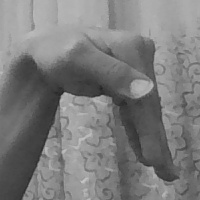

del


In [94]:
def predict(model, image_path):
    model.eval()
    image = Image.open(image_path).convert("L")
    display(image)
    image = transform(image).unsqueeze(0).to(device)  # Add batch dimension
    output = model(image)
    _, predicted = torch.max(output, 1)
    print(reverse_mapping[predicted.item()])
    return chr(predicted.item()) #+ ord('A'))  # Convert label to letter

# Example usage
model.load_state_dict(torch.load("sign_language_model.pth"))
letter = predict(model, 'MiniDataset/train/del/del (291).jpg')
#print("Predicted letter:", letter)